In [1]:
!wget -O NCT-CRC-HE-100K.zip https://zenodo.org/record/1214456/files/NCT-CRC-HE-100K.zip
!unzip -qq NCT-CRC-HE-100K.zip -d train

--2025-01-26 06:12:07--  https://zenodo.org/record/1214456/files/NCT-CRC-HE-100K.zip
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.48.194, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1214456/files/NCT-CRC-HE-100K.zip [following]
--2025-01-26 06:12:08--  https://zenodo.org/records/1214456/files/NCT-CRC-HE-100K.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 11690284003 (11G) [application/octet-stream]
Saving to: ‘NCT-CRC-HE-100K.zip’

NCT-CRC-HE-100K.zip 100%[===================>]  10.89G  11.5MB/s    in 15m 12s 

2025-01-26 06:27:20 (12.2 MB/s) - ‘NCT-CRC-HE-100K.zip’ saved [11690284003/11690284003]



In [3]:
!pip install torchinfo

In [4]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
import numpy as np
from tqdm import tqdm

import itertools
from torchinfo import summary
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
from PIL import Image

from matplotlib import pyplot as plt

import random
import torchvision.transforms.functional as TF

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

In [5]:
class ConvNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super(ConvNorm, self).__init__()
        self.linear = nn.Conv2d(
            in_channels, out_channels, kernel_size=kernel_size,
            stride=stride, padding=padding, bias=False
        )
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.linear(x)
        x = self.bn(x)
        return x

In [6]:
class Stem16(nn.Module):
    def __init__(self):
        super(Stem16, self).__init__()
        self.conv1 = ConvNorm(3, 32)
        self.act1 = nn.Hardswish()
        self.conv2 = ConvNorm(32, 64)
        self.act2 = nn.Hardswish()
        self.conv3 = ConvNorm(64, 128)
        self.act3 = nn.Hardswish()
        self.conv4 = ConvNorm(128, 256)

    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.act2(self.conv2(x))
        x = self.act3(self.conv3(x))
        x = self.conv4(x)
        return x

In [7]:
class LinearNorm(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearNorm, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias=False)
        self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x):

        if x.dim() == 3:
            B, N, C = x.shape
            x = x.reshape(B * N, C)
            x = self.bn(self.linear(x))
            x = x.reshape(B, N, -1)
        else:
            x = self.bn(self.linear(x))
        return x

In [8]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads, attn_ratio=2):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        inner_dim = head_dim * num_heads * 3
        self.qkv = LinearNorm(dim, inner_dim)

        self.proj = nn.Sequential(
            nn.Hardswish(),
            LinearNorm(dim, dim)
        )

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x)
        qkv = qkv.view(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj(x)

In [9]:
class LevitMlp(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(LevitMlp, self).__init__()
        self.ln1 = LinearNorm(in_features, hidden_features)
        self.act = nn.Hardswish()
        self.drop = nn.Dropout(p=0.5, inplace=False)#dropout 적용
        self.ln2 = LinearNorm(hidden_features, out_features)

    def forward(self, x):
        x = self.ln1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.ln2(x)
        return x

In [10]:
class LevitBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=2):
        super(LevitBlock, self).__init__()
        self.attn = Attention(dim, num_heads)
        self.drop_path1 = nn.Identity()
        self.mlp = LevitMlp(dim, dim * mlp_ratio, dim)
        self.drop_path2 = nn.Identity()

    def forward(self, x):
        x = x + self.drop_path1(self.attn(x))
        x = x + self.drop_path2(self.mlp(x))
        return x

In [11]:
class CNNDownsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CNNDownsample, self).__init__()
        self.out_channels = out_channels
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.act = nn.Hardswish()

    def forward(self, x):
        # print(x.shape)
        B, N, C = x.shape # (B, N, C)  N=H*W (16 * 16 = 196)
        H = int(np.sqrt(N))
        x = x.view(B, H, H, C).permute(0, 3, 1, 2)
        x = self.conv(x)
        x = self.act(x)
        x = x.permute(0, 2, 3, 1).view(B, -1, self.out_channels)
        return x

In [12]:
class LevitStage(nn.Module):
    def __init__(self, dim, out_dim, num_heads, num_blocks, downsample=True):
        super(LevitStage, self).__init__()
        self.downsample = CNNDownsample(dim, out_dim) if downsample else nn.Identity()
        self.blocks = nn.Sequential(*[LevitBlock(out_dim, num_heads) for _ in range(num_blocks)])

    def forward(self, x):
        x = self.downsample(x)
        x = self.blocks(x)
        return x

In [13]:
class ConvLevitStage(nn.Module):
    def __init__(self, in_channels, out_channels, num_blocks, kernel_size, stride, padding):
        super(ConvLevitStage, self).__init__()
        self.layers = nn.Sequential(
            *[nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size, stride, padding)
              for i in range(num_blocks)],
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.layers(x)

In [14]:
class NormLinear(nn.Module):
    def __init__(self, in_features, out_features, dropout_prob=0.5):#drop_out_0.5 적용
        super(NormLinear, self).__init__()
        self.bn = nn.BatchNorm1d(in_features)
        self.drop = nn.Dropout(p=dropout_prob, inplace=False)
        self.linear = nn.Linear(in_features, out_features, bias=True)

    def forward(self, x):
        x = self.bn(x)
        x = self.drop(x)
        x = self.linear(x)
        return x

In [15]:
class LevitDistilled(nn.Module):
    def __init__(self, num_classes=9):
        super(LevitDistilled, self).__init__()

        self.stem = Stem16()

        self.stage1 = LevitStage(dim=256, out_dim=256, num_heads=4, num_blocks=2, downsample=False) # block 수 적용
        self.stage2 = LevitStage(dim=256, out_dim=384, num_heads=6, num_blocks=2, downsample=True)

        self.conv1x1 = nn.Sequential(
            nn.Conv2d(384, 512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self.head = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)
        self.head_dist = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)

    def forward(self, x):
        x = self.stem(x)

        B, C, H, W = x.shape
        x = x.view(B, C, -1).transpose(1, 2)
        x = self.stage1(x)
        x = self.stage2(x)

        H = W = int(x.shape[1]**0.5)
        x = x.transpose(1, 2).view(B, 384, H, W)

        x = self.conv1x1(x)

        x = torch.mean(x, dim=(2, 3))
        out = self.head(x)
        out_dist = self.head_dist(x)
        return out

In [16]:
model = LevitDistilled()
print(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

batch_size = 64
learning_rate = 5e-4
decay_rate = 1e-6
num_epochs = 30

LevitDistilled(
  (stem): Stem16(
    (conv1): ConvNorm(
      (linear): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act1): Hardswish()
    (conv2): ConvNorm(
      (linear): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act2): Hardswish()
    (conv3): ConvNorm(
      (linear): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act3): Hardswish()
    (conv4): ConvNorm(
      (linear): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (stage1): LevitStage(
  

In [17]:
print(summary(model, input_size=(32, 3, 224, 224)))

Layer (type:depth-idx)                                  Output Shape              Param #
LevitDistilled                                          [32, 9]                   --
├─Stem16: 1-1                                           [32, 256, 14, 14]         --
│    └─ConvNorm: 2-1                                    [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        64
│    └─Hardswish: 2-2                                   [32, 32, 112, 112]        --
│    └─ConvNorm: 2-3                                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-3                                 [32, 64, 56, 56]          18,432
│    │    └─BatchNorm2d: 3-4                            [32, 64, 56, 56]          128
│    └─Hardswish: 2-4                                   [32, 64, 56, 56]          --
│    └─ConvNorm: 2-5                                  

In [18]:
print(summary(model, input_size=(32, 3, 224, 224), verbose=2))

Layer (type:depth-idx)                                  Output Shape              Param #
LevitDistilled                                          [32, 9]                   --
├─Stem16: 1-1                                           [32, 256, 14, 14]         --
│    └─conv1.linear.weight                                                        ├─864
│    └─conv1.bn.weight                                                            ├─32
│    └─conv1.bn.bias                                                              ├─32
│    └─conv2.linear.weight                                                        ├─18,432
│    └─conv2.bn.weight                                                            ├─64
│    └─conv2.bn.bias                                                              ├─64
│    └─conv3.linear.weight                                                        ├─73,728
│    └─conv3.bn.weight                                                            ├─128
│    └─conv3.bn.bias              

In [19]:
train_dir = './train/NCT-CRC-HE-100K'

In [20]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [21]:
dataset = datasets.ImageFolder(root=train_dir, transform=transform)

In [22]:
data_paths, labels = zip(*dataset.samples)
labels = np.array(labels)

# 7 : 3 split
train_idx, tmp_idx, _, tmp_labels = train_test_split(
    np.arange(len(labels)), labels, test_size=0.3, stratify=labels, random_state=42
)

# 3 -> 1.5 : 1.5 split
val_idx, test_idx = train_test_split(
    tmp_idx, test_size=0.5, stratify=tmp_labels, random_state=42
)

train_data = Subset(dataset, train_idx)
val_data = Subset(dataset, val_idx)
test_data = Subset(dataset, test_idx)

In [23]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f"Train set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

Train set size: 70000
Validation set size: 15000
Test set size: 15000


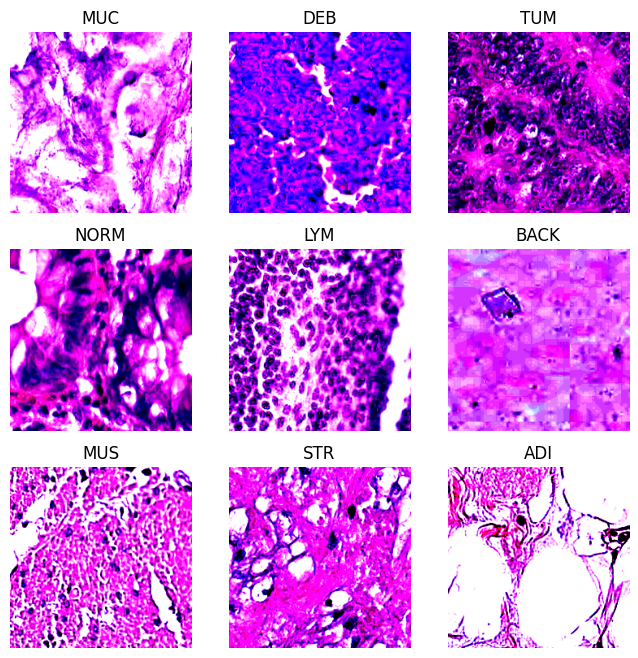

In [24]:
# Show one example per class from the training dataset
import matplotlib.pyplot as plt

# Prepare a dictionary to store one example per class
class_examples = {}
for images, labels in train_loader:
    for img, label in zip(images, labels):
        label = label.item()
        if label not in class_examples:
            class_examples[label] = img
        # Stop if we already have one example for each class
        if len(class_examples) == len(dataset.classes):
            break
    if len(class_examples) == len(dataset.classes):
        break

# Display the images and their labels
figure = plt.figure(figsize=(8, 8))
cols = 3  # You can adjust the number of columns as needed
rows = (len(dataset.classes) + cols - 1) // cols  # Calculate required rows
for i, (label, img) in enumerate(class_examples.items(), start=1):
    figure.add_subplot(rows, cols, i)
    plt.title(dataset.classes[label])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0).numpy())  # Convert tensor to numpy for display
plt.show()

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [26]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [27]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {accuracy:.2f}%")
    train_losses.append(epoch_loss)
    train_accuracies.append(accuracy)

In [28]:
def evaluate(model, data_loader, criterion, device, phase="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"{phase}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Save all labels and predictions for balanced accuracy
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    balanced_acc = balanced_accuracy_score(all_labels, all_predictions)

    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    val_losses.append(epoch_loss)
    val_accuracies.append(accuracy)

In [29]:
def measure_inference_time(model, data_loader, device):
    model.eval()
    times = []

    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            start_time = torch.cuda.Event(enable_timing=True)
            end_time = torch.cuda.Event(enable_timing=True)

            start_time.record()
            _ = model(inputs)  # inference 수행
            end_time.record()

            # 시간 측정
            torch.cuda.synchronize()  # CUDA에서 모든 커널이 완료될 때까지 대기
            elapsed_time = start_time.elapsed_time(end_time)  # 밀리초 단위로 반환
            times.append(elapsed_time)

    # 통계량 계산
    times_np = np.array(times)
    total_inferences = len(times_np)
    avg_time = np.mean(times_np)
    std_dev = np.std(times_np)
    max_time = np.max(times_np)
    min_time = np.min(times_np)

    # 결과 출력
    print(f"Inference Time Measurement Results:")
    print(f"Total Inferences: {total_inferences}")
    print(f"Average Time: {avg_time:.2f} ms")
    print(f"Standard Deviation: {std_dev:.2f} ms")
    print(f"Maximum Time: {max_time:.2f} ms")
    print(f"Minimum Time: {min_time:.2f} ms")

    return times

In [30]:
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train(model, train_loader, criterion, optimizer, device)
    evaluate(model, val_loader, criterion, device, phase="Validation")


Epoch 1/30


Training: 100%|██████████| 1094/1094 [02:26<00:00,  7.47it/s]


Train Loss: 0.4388, Train Accuracy: 84.35%


Validation: 100%|██████████| 235/235 [00:24<00:00,  9.51it/s]


Validation Loss: 0.3226, Validation Accuracy: 88.45%
Balanced Accuracy: 0.8890

Epoch 2/30


Training: 100%|██████████| 1094/1094 [02:20<00:00,  7.79it/s]


Train Loss: 0.1951, Train Accuracy: 93.25%


Validation: 100%|██████████| 235/235 [00:24<00:00,  9.66it/s]


Validation Loss: 0.3652, Validation Accuracy: 88.07%
Balanced Accuracy: 0.8704

Epoch 3/30


Training: 100%|██████████| 1094/1094 [02:16<00:00,  8.00it/s]


Train Loss: 0.1375, Train Accuracy: 95.32%


Validation: 100%|██████████| 235/235 [00:24<00:00,  9.65it/s]


Validation Loss: 0.1581, Validation Accuracy: 94.92%
Balanced Accuracy: 0.9491

Epoch 4/30


Training: 100%|██████████| 1094/1094 [02:17<00:00,  7.96it/s]


Train Loss: 0.1093, Train Accuracy: 96.34%


Validation: 100%|██████████| 235/235 [00:24<00:00,  9.64it/s]


Validation Loss: 0.1578, Validation Accuracy: 94.83%
Balanced Accuracy: 0.9440

Epoch 5/30


Training: 100%|██████████| 1094/1094 [02:17<00:00,  7.96it/s]


Train Loss: 0.0924, Train Accuracy: 96.89%


Validation: 100%|██████████| 235/235 [00:24<00:00,  9.64it/s]


Validation Loss: 0.0908, Validation Accuracy: 97.09%
Balanced Accuracy: 0.9703

Epoch 6/30


Training: 100%|██████████| 1094/1094 [02:17<00:00,  7.94it/s]


Train Loss: 0.0788, Train Accuracy: 97.33%


Validation: 100%|██████████| 235/235 [00:24<00:00,  9.72it/s]


Validation Loss: 0.0973, Validation Accuracy: 96.78%
Balanced Accuracy: 0.9657

Epoch 7/30


Training: 100%|██████████| 1094/1094 [02:17<00:00,  7.93it/s]


Train Loss: 0.0682, Train Accuracy: 97.74%


Validation: 100%|██████████| 235/235 [00:24<00:00,  9.67it/s]


Validation Loss: 0.1046, Validation Accuracy: 96.48%
Balanced Accuracy: 0.9669

Epoch 8/30


Training: 100%|██████████| 1094/1094 [02:17<00:00,  7.93it/s]


Train Loss: 0.0596, Train Accuracy: 98.01%


Validation: 100%|██████████| 235/235 [00:24<00:00,  9.57it/s]


Validation Loss: 0.1442, Validation Accuracy: 95.25%
Balanced Accuracy: 0.9537

Epoch 9/30


Training: 100%|██████████| 1094/1094 [02:17<00:00,  7.97it/s]


Train Loss: 0.0537, Train Accuracy: 98.18%


Validation: 100%|██████████| 235/235 [00:24<00:00,  9.67it/s]


Validation Loss: 0.0863, Validation Accuracy: 97.25%
Balanced Accuracy: 0.9710

Epoch 10/30


Training: 100%|██████████| 1094/1094 [02:18<00:00,  7.92it/s]


Train Loss: 0.0488, Train Accuracy: 98.38%


Validation: 100%|██████████| 235/235 [00:24<00:00,  9.70it/s]


Validation Loss: 0.1096, Validation Accuracy: 96.45%
Balanced Accuracy: 0.9655

Epoch 11/30


Training: 100%|██████████| 1094/1094 [02:17<00:00,  7.98it/s]


Train Loss: 0.0422, Train Accuracy: 98.56%


Validation: 100%|██████████| 235/235 [00:24<00:00,  9.71it/s]


Validation Loss: 0.0685, Validation Accuracy: 97.71%
Balanced Accuracy: 0.9774

Epoch 12/30


Training: 100%|██████████| 1094/1094 [02:17<00:00,  7.95it/s]


Train Loss: 0.0387, Train Accuracy: 98.70%


Validation: 100%|██████████| 235/235 [00:24<00:00,  9.63it/s]


Validation Loss: 0.1444, Validation Accuracy: 95.71%
Balanced Accuracy: 0.9567

Epoch 13/30


Training: 100%|██████████| 1094/1094 [02:17<00:00,  7.93it/s]


Train Loss: 0.0317, Train Accuracy: 98.94%


Validation: 100%|██████████| 235/235 [00:24<00:00,  9.66it/s]


Validation Loss: 0.0720, Validation Accuracy: 97.72%
Balanced Accuracy: 0.9772

Epoch 14/30


Training: 100%|██████████| 1094/1094 [02:18<00:00,  7.92it/s]


Train Loss: 0.0316, Train Accuracy: 98.93%


Validation: 100%|██████████| 235/235 [00:24<00:00,  9.58it/s]


Validation Loss: 0.0584, Validation Accuracy: 98.01%
Balanced Accuracy: 0.9791

Epoch 15/30


Training: 100%|██████████| 1094/1094 [02:17<00:00,  7.95it/s]


Train Loss: 0.0306, Train Accuracy: 98.97%


Validation: 100%|██████████| 235/235 [00:24<00:00,  9.61it/s]


Validation Loss: 0.0416, Validation Accuracy: 98.49%
Balanced Accuracy: 0.9853

Epoch 16/30


Training: 100%|██████████| 1094/1094 [02:17<00:00,  7.97it/s]


Train Loss: 0.0235, Train Accuracy: 99.20%


Validation: 100%|██████████| 235/235 [00:24<00:00,  9.65it/s]


Validation Loss: 0.0995, Validation Accuracy: 97.23%
Balanced Accuracy: 0.9743

Epoch 17/30


Training: 100%|██████████| 1094/1094 [02:17<00:00,  7.96it/s]


Train Loss: 0.0264, Train Accuracy: 99.12%


Validation: 100%|██████████| 235/235 [00:24<00:00,  9.67it/s]


Validation Loss: 0.0733, Validation Accuracy: 97.75%
Balanced Accuracy: 0.9762

Epoch 18/30


Training: 100%|██████████| 1094/1094 [02:17<00:00,  7.96it/s]


Train Loss: 0.0213, Train Accuracy: 99.31%


Validation: 100%|██████████| 235/235 [00:24<00:00,  9.64it/s]


Validation Loss: 0.0650, Validation Accuracy: 97.93%
Balanced Accuracy: 0.9783

Epoch 19/30


Training: 100%|██████████| 1094/1094 [02:17<00:00,  7.95it/s]


Train Loss: 0.0202, Train Accuracy: 99.34%


Validation: 100%|██████████| 235/235 [00:24<00:00,  9.72it/s]


Validation Loss: 0.1394, Validation Accuracy: 96.08%
Balanced Accuracy: 0.9573

Epoch 20/30


Training: 100%|██████████| 1094/1094 [02:17<00:00,  7.95it/s]


Train Loss: 0.0201, Train Accuracy: 99.31%


Validation: 100%|██████████| 235/235 [00:24<00:00,  9.69it/s]


Validation Loss: 0.0444, Validation Accuracy: 98.56%
Balanced Accuracy: 0.9863

Epoch 21/30


Training: 100%|██████████| 1094/1094 [02:17<00:00,  7.95it/s]


Train Loss: 0.0176, Train Accuracy: 99.41%


Validation: 100%|██████████| 235/235 [00:24<00:00,  9.69it/s]


Validation Loss: 0.0569, Validation Accuracy: 98.43%
Balanced Accuracy: 0.9846

Epoch 22/30


Training: 100%|██████████| 1094/1094 [02:17<00:00,  7.93it/s]


Train Loss: 0.0164, Train Accuracy: 99.47%


Validation: 100%|██████████| 235/235 [00:24<00:00,  9.61it/s]


Validation Loss: 0.0409, Validation Accuracy: 98.85%
Balanced Accuracy: 0.9883

Epoch 23/30


Training: 100%|██████████| 1094/1094 [02:17<00:00,  7.94it/s]


Train Loss: 0.0163, Train Accuracy: 99.47%


Validation: 100%|██████████| 235/235 [00:24<00:00,  9.59it/s]


Validation Loss: 0.0535, Validation Accuracy: 98.38%
Balanced Accuracy: 0.9824

Epoch 24/30


Training: 100%|██████████| 1094/1094 [02:17<00:00,  7.93it/s]


Train Loss: 0.0139, Train Accuracy: 99.51%


Validation: 100%|██████████| 235/235 [00:24<00:00,  9.63it/s]


Validation Loss: 0.0773, Validation Accuracy: 98.01%
Balanced Accuracy: 0.9805

Epoch 25/30


Training: 100%|██████████| 1094/1094 [02:18<00:00,  7.92it/s]


Train Loss: 0.0155, Train Accuracy: 99.46%


Validation: 100%|██████████| 235/235 [00:24<00:00,  9.66it/s]


Validation Loss: 0.2047, Validation Accuracy: 94.85%
Balanced Accuracy: 0.9480

Epoch 26/30


Training: 100%|██████████| 1094/1094 [02:18<00:00,  7.92it/s]


Train Loss: 0.0131, Train Accuracy: 99.54%


Validation: 100%|██████████| 235/235 [00:24<00:00,  9.63it/s]


Validation Loss: 0.0397, Validation Accuracy: 98.93%
Balanced Accuracy: 0.9884

Epoch 27/30


Training: 100%|██████████| 1094/1094 [02:18<00:00,  7.91it/s]


Train Loss: 0.0118, Train Accuracy: 99.59%


Validation: 100%|██████████| 235/235 [00:24<00:00,  9.58it/s]


Validation Loss: 0.0325, Validation Accuracy: 98.97%
Balanced Accuracy: 0.9898

Epoch 28/30


Training: 100%|██████████| 1094/1094 [02:17<00:00,  7.93it/s]


Train Loss: 0.0130, Train Accuracy: 99.56%


Validation: 100%|██████████| 235/235 [00:24<00:00,  9.65it/s]


Validation Loss: 0.0784, Validation Accuracy: 97.92%
Balanced Accuracy: 0.9791

Epoch 29/30


Training: 100%|██████████| 1094/1094 [02:18<00:00,  7.91it/s]


Train Loss: 0.0111, Train Accuracy: 99.64%


Validation: 100%|██████████| 235/235 [00:24<00:00,  9.63it/s]


Validation Loss: 0.0445, Validation Accuracy: 98.76%
Balanced Accuracy: 0.9875

Epoch 30/30


Training: 100%|██████████| 1094/1094 [02:18<00:00,  7.93it/s]


Train Loss: 0.0115, Train Accuracy: 99.61%


Validation: 100%|██████████| 235/235 [00:24<00:00,  9.65it/s]

Validation Loss: 0.0764, Validation Accuracy: 98.11%
Balanced Accuracy: 0.9804


In [31]:
print("\nFinal Test Evaluation")
evaluate(model, test_loader, criterion, device, phase="Test")


Final Test Evaluation


Test: 100%|██████████| 235/235 [00:24<00:00,  9.48it/s]

Test Loss: 0.0800, Test Accuracy: 98.09%
Balanced Accuracy: 0.9807


In [32]:
print("train_loss length : ", len(train_losses))
print("train_acc length : ", len(train_accuracies))
print("val_loss length : ", len(val_losses))
print("val_acc length : ", len(val_accuracies))

print("val_adj : ", len(val_losses[:num_epochs]))
print("val_acc_adj : ", len(val_accuracies[:num_epochs]))

train_loss length :  30
train_acc length :  30
val_loss length :  31
val_acc length :  31
val_adj :  30
val_acc_adj :  30


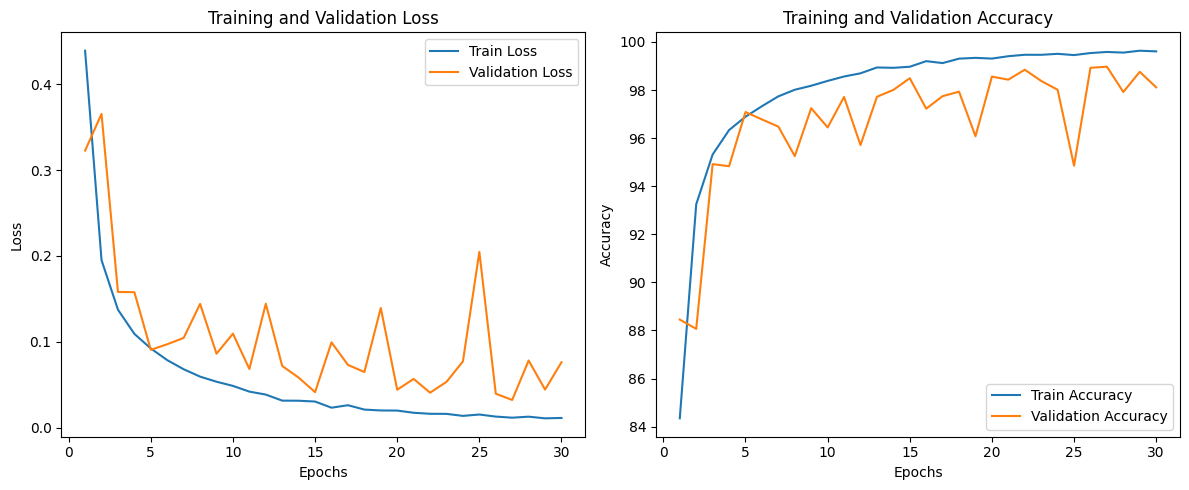

In [33]:
# Plot the metrics
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses[:num_epochs], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, val_accuracies[:num_epochs], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [34]:
times = measure_inference_time(model, test_loader, device)

Inference Time Measurement Results:
Total Inferences: 235
Average Time: 8.13 ms
Standard Deviation: 0.15 ms
Maximum Time: 8.65 ms
Minimum Time: 5.87 ms


In [35]:
from torch import profiler

dummy_input = torch.randn(32, 3, 224, 224).cuda()

# Profiling inference
with profiler.profile(
    activities=[
       profiler.ProfilerActivity.CPU,
        profiler.ProfilerActivity.CUDA,  # Include if using GPU
    ],
    on_trace_ready=profiler.tensorboard_trace_handler("./logs"),  # Optional logging
    record_shapes=True,
    with_stack=True
) as prof:
    with torch.no_grad():
        model(dummy_input)


# Print results
print(prof.key_averages().table(sort_by="cuda_time_total" if torch.cuda.is_available() else "cpu_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                           aten::matmul         2.35%     349.213us        19.76%       2.942ms     122.590us       0.000us         0.00%       2.539ms     105.794us            24  
                                           aten::linear         0.57%      85.073us        14.16%       2.109ms     117.149us       0.000us         0.00%       1.832ms     101.764us            18  
         

In [36]:
save_path = "HoViT_NCT-CRC-HE-100K.pth"
torch.save(model.state_dict(), save_path)
print(f"Model weights saved to {save_path}")

Model weights saved to HoViT_NCT-CRC-HE-100K.pth


In [37]:
from sklearn.metrics import f1_score, recall_score, precision_score, roc_curve, auc

def score_evaluate(model, data_loader, criterion, device, phase="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"{phase}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    overall_f1 = f1_score(all_labels, all_preds, average="macro")
    overall_recall = recall_score(all_labels, all_preds, average="macro")
    overall_precision = precision_score(all_labels, all_preds, average="macro")

    f1_per_class = f1_score(all_labels, all_preds, average=None)
    recall_per_class = recall_score(all_labels, all_preds, average=None)
    precision_per_class = precision_score(all_labels, all_preds, average=None)
    class_labels = sorted(set(all_labels))

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")
    val_losses.append(epoch_loss)
    val_accuracies.append(accuracy)

    print(f"Overall - F1: {overall_f1:.4f}, Recall: {overall_recall:.4f}, Precision: {overall_precision:.4f}")
    print("Per-Class Metrics:")
    for i, label in enumerate(class_labels):
        print(f"Class {label} - F1: {f1_per_class[i]:.4f}, Recall: {recall_per_class[i]:.4f}, Precision: {precision_per_class[i]:.4f}")

    return overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class

In [38]:
from sklearn.preprocessing import label_binarize

def roc_auc(model, data_loader, device, num_classes):

    y = ["F1", "Precision", "Recall"]

    model.eval()
    all_labels = []
    all_scores = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="ROC AUC"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_scores.extend(outputs.cpu().numpy())

    all_labels = label_binarize(all_labels, classes=list(range(num_classes)))
    print(f"Binarized all_labels shape: {all_labels.shape}")
    print(f"All_scores shape: {np.array(all_scores).shape}")

    fpr, tpr, _ = roc_curve(all_labels.ravel(), np.array(all_scores).ravel())
    roc_auc_value = auc(fpr, tpr)

    plt.figure(figsize=(9, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_value:0.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    print(f"Overall ROC AUC: {roc_auc_value:.4f}")

    return fpr, tpr, roc_auc_value

In [39]:
overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class = score_evaluate(model, test_loader, criterion, device, phase="Test")

Test: 100%|██████████| 235/235 [00:24<00:00,  9.60it/s]


Test Loss: 0.0800, Test Accuracy: 98.09%
Overall - F1: 0.9809, Recall: 0.9807, Precision: 0.9813
Per-Class Metrics:
Class 0 - F1: 0.9945, Recall: 0.9891, Precision: 1.0000
Class 1 - F1: 0.9965, Recall: 0.9994, Precision: 0.9937
Class 2 - F1: 0.9676, Recall: 0.9942, Precision: 0.9423
Class 3 - F1: 0.9980, Recall: 0.9971, Precision: 0.9988
Class 4 - F1: 0.9790, Recall: 0.9618, Precision: 0.9969
Class 5 - F1: 0.9763, Recall: 0.9636, Precision: 0.9894
Class 6 - F1: 0.9871, Recall: 0.9894, Precision: 0.9849
Class 7 - F1: 0.9437, Recall: 0.9464, Precision: 0.9410
Class 8 - F1: 0.9853, Recall: 0.9856, Precision: 0.9851


<Figure size 2000x1200 with 0 Axes>

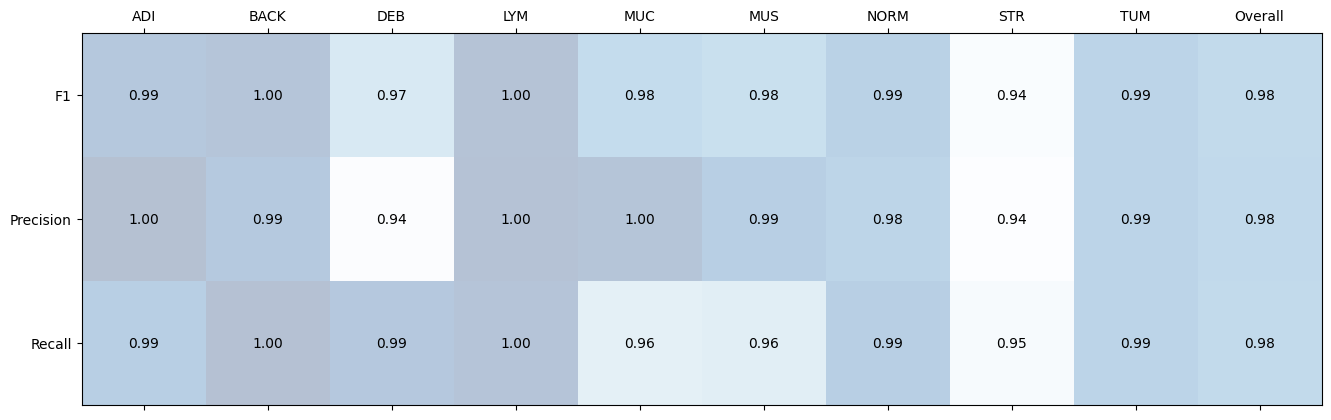

In [40]:
x = ["ADI", "BACK", "DEB", "LYM", "MUC", "MUS", "NORM", 'STR', "TUM"]
y = ["F1", "Precision", "Recall"]

f1_score_list = []
precision_score_list = []
recall_score_list = []

for i, class_name in enumerate(x):
    f1_score_list.append(f1_per_class[i])
    precision_score_list.append(precision_per_class[i])
    recall_score_list.append(recall_per_class[i])

x.append("Overall")
f1_score_list.append(overall_f1)
precision_score_list.append(overall_precision)
recall_score_list.append(overall_recall)

score_list = [f1_score_list, precision_score_list, recall_score_list]
score_list = np.array(score_list)
plt.figure(figsize=(20, 12))
score_cm = plt.matshow(score_list, cmap=plt.cm.Blues, alpha=0.3)
plt.xticks(range(len(x)), x)
plt.yticks(range(len(y)), y)
for i in range(len(y)):
    for j in range(len(x)):
        # 행렬의 각각의 수치를 각 칸의 중앙에 넣어준다
        plt.text(x=j, y=i,
                     s="{:.2f}".format(score_list[i, j]),
                     va='center',
                     ha='center',
                     )